# September 29, 2022: Reimplement Najafi et al. 2017
I have the trial level responses for Emoprox2 paradigm. Mashid analysed Emoprox1 paradigm, and her ISC matrices were visually distinct for Approach and Retreat segments. Here I am replicating her results and seeing how similar are my matrices with her's.

In [1]:
import os 
import sys
from os.path import join as pjoin
import numpy as np
import scipy as sp
import pandas as pd
from tqdm.notebook import tqdm
import pickle, random
import csv
from copy import deepcopy

from brainiak.isc import (
    compute_correlation
)

# main dirs
proj_dir = pjoin(os.environ['HOME'], 'network_dynamics')
results_dir = f"{proj_dir}/results"
month_dir = f"{proj_dir}/nb/sep22"

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

import cmasher as cmr #CITE ITS PAPER IN YOUR MANUSCRIPT

# folders
sys.path.insert(0, proj_dir)
import helpers.dataset_utils_v1 as dataset_utils

In [2]:
class ARGS(): pass
args = ARGS()

args.SEED = 74
np.random.seed(args.SEED)

args.APPR = 1
args.RETR = -1
args.LABELS = [args.APPR, args.RETR]
args.LABEL_NAMES = ['APPR', 'RETR']
args.NAMES = ['APPR', 'RETR']
args.TRIAL_LEN = {name:None for name in args.LABEL_NAMES}
args.MIN_TRS = {name:None for name in args.LABEL_NAMES}
args.MIN_TRIALS = {name:7 for name in args.LABEL_NAMES}
args.near_miss_thresh = 0.7
args.near_miss_width = 8
args.hemo_lag = 4
args.TR = 1.25

In [3]:
args.proj_dir = proj_dir

with open(
    f"/home/joyneelm/FORAGING/local/notebooks/dynamical_systems_emoprox/emoprox_motion_parameters.pkl", 
    'rb'
) as f:
    motion_df = pickle.load(f)
# motion_df

args.roi_set_name = 'mashid'
args.main_data_dir = (
    f"{proj_dir}/data/emoprox2/data/rois_{args.roi_set_name}"
)
# exploratory data
args.subjects = np.unique(motion_df.pid.values)
random.Random(args.SEED).shuffle(args.subjects)
args.explor_subjects = args.subjects[ : round(0.25 * len(args.subjects))]

# ROIs
args = dataset_utils.get_mashid_rois(args)
args = dataset_utils.get_mashid_plot_tick_labels(args)

# condition responses
X = dataset_utils.get_emo2_trial_level_responses(args, motion_df)
# args.plot_colors = {'APPR': 'firebrick', 'RETR': 'cornflowerblue'}
# dataset_utils.plot_emo2_responses(args, X)

[13 12 12  8]
[13 25 37]
[ 7 19 31 41]
['Salience' 'Executive' 'Task negative' 'Subcortical']


  0%|          | 0/30 [00:00<?, ?it/s]

In [4]:
def get_block_time_series(args, X):
    ts = {}
    for name in X.keys():
        for idx_time in range(args.MIN_TRS[name]):
            block = f"{name}_TR{idx_time}"
            ts[block] = []
            for x in X[name]:
                if len(x) < args.MIN_TRIALS[name]: continue
                ts[block].append(x[:args.MIN_TRIALS[name], idx_time, :])
            ts[block] = np.stack(ts[block], axis=-1)
    return ts

ts = get_block_time_series(args, X)

In [5]:
# ISC
def get_iscs(args, ts):
    ensure_symmetry = lambda A: (A + A.T)/2 # projection onto the space of symmetric matrices
    isfcs = {}
    for block in ts.keys():
        ts_block = np.rollaxis(ts[block], 2, 0)
        isfcs[block] = [
            compute_correlation(
                np.ascontiguousarray(ts_block[idx_subj].T),
                np.ascontiguousarray(
                    np.nanmean(
                        np.delete(ts_block, idx_subj, axis=0),
                        axis=0
                    ).T
                ),
                return_nans=True
            )
            for idx_subj in range(ts_block.shape[0])
        ]
        isfcs[block] = np.stack(isfcs[block], axis=-1)
        isfcs[block] = np.nanmean(isfcs[block], axis=-1)
        isfcs[block] = ensure_symmetry(isfcs[block])
    return isfcs

iscs = get_iscs(args, ts)

/tmp/ipykernel_15778/2269369279.py:21: RuntimeWarning: Mean of empty slice
  isfcs[block] = np.nanmean(isfcs[block], axis=-1)


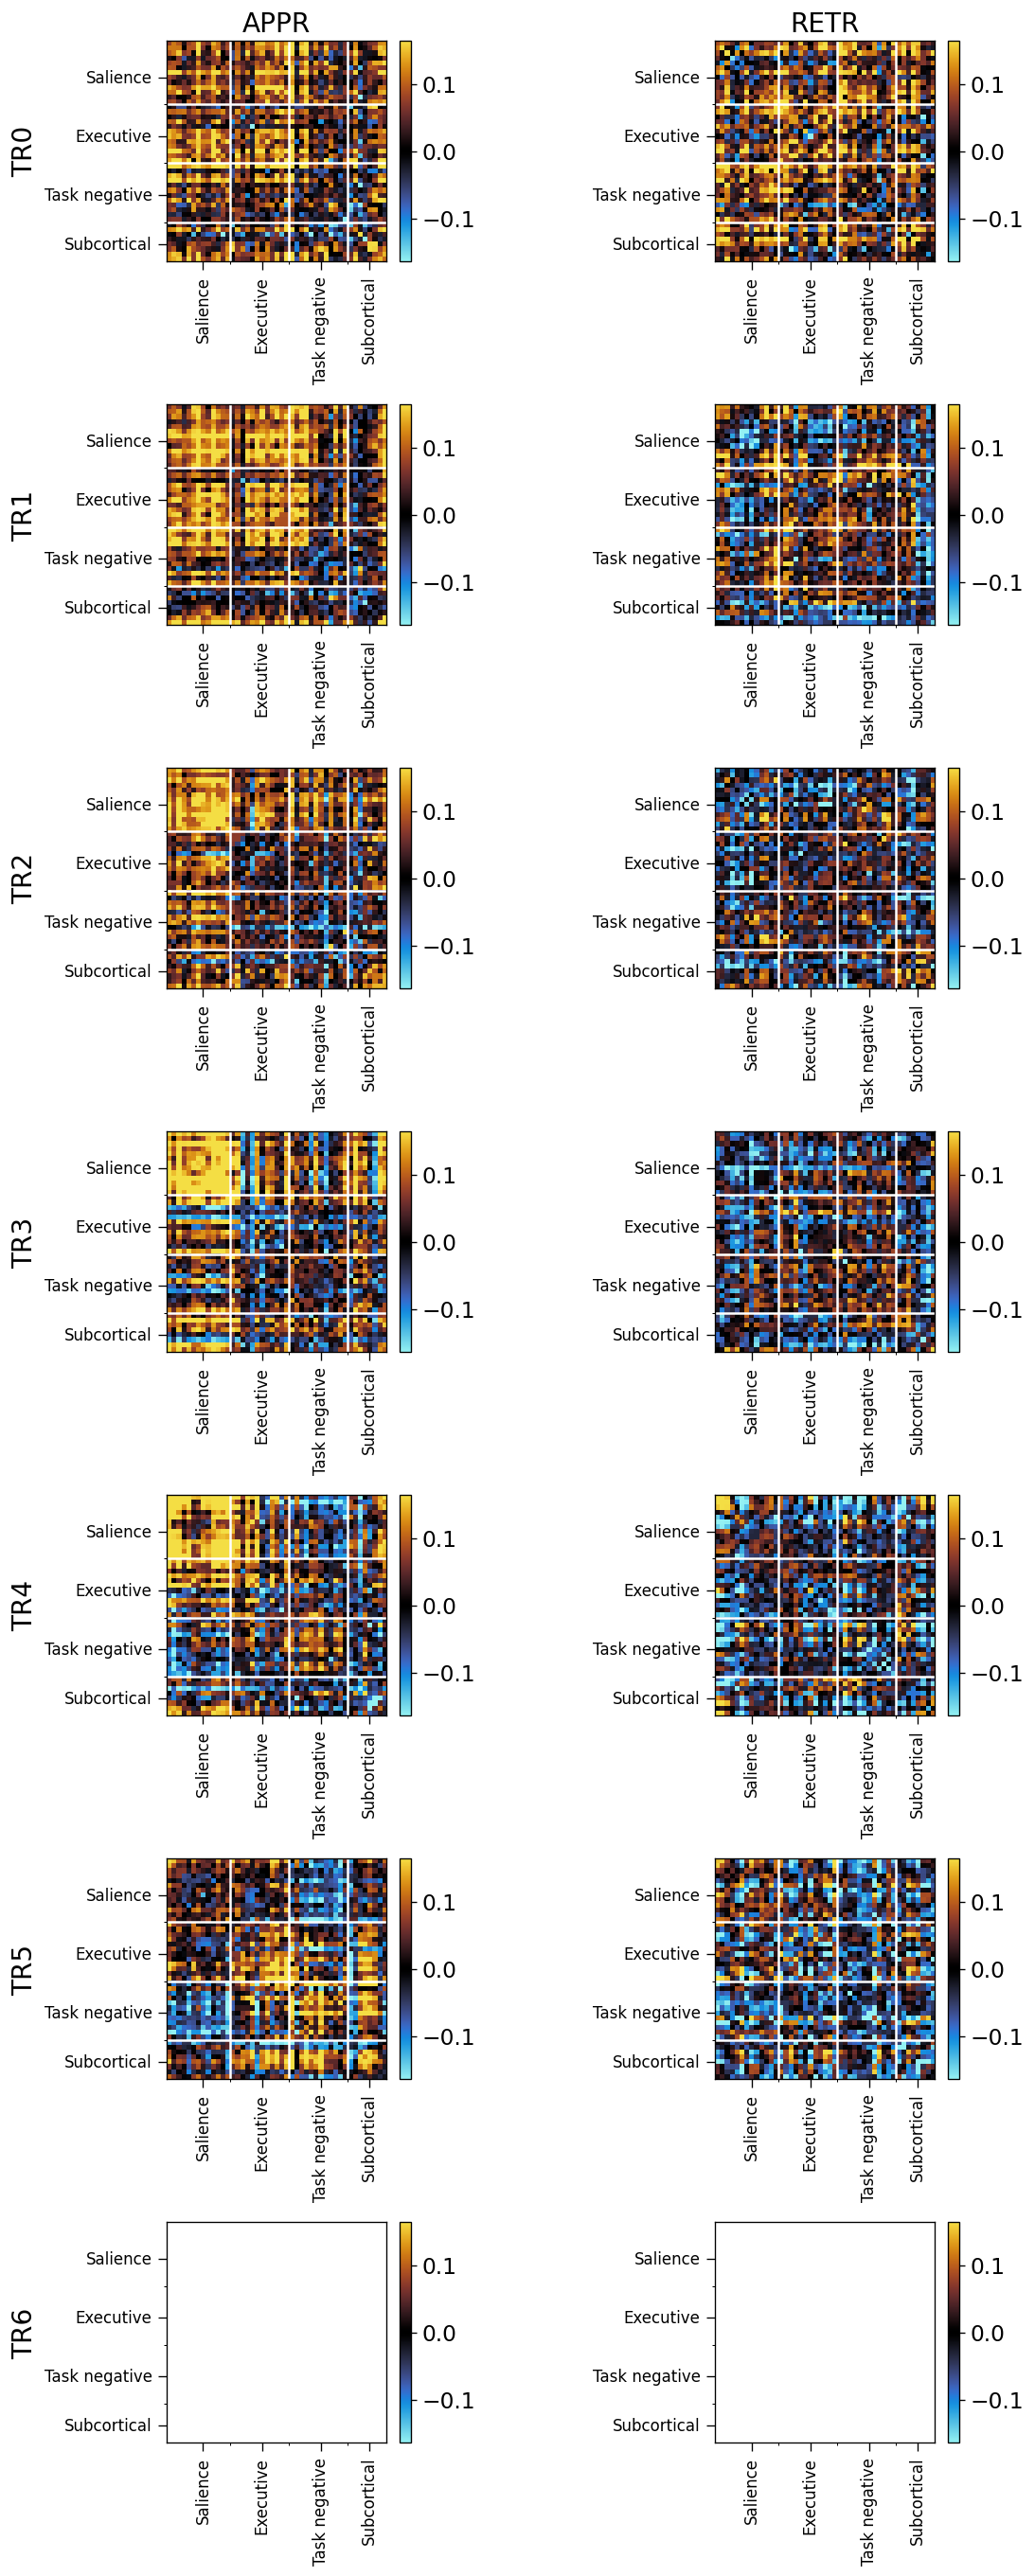

In [6]:
def get_min_max(d):
    '''
    min and max values of the matrices:
    used in plotting the matrices
    '''
    vals = []
    for block in d.keys():
        vals.append(d[block])
    vals = np.concatenate(vals, axis=0).flatten()
    vmin = np.nanquantile(vals, q=0.05)
    vmax = np.nanquantile(vals, q=0.95)
    return -max(-vmin, vmax), max(-vmin, vmax)

def plot_iscs(args, iscs, cmap=cmr.iceburn):
    vmin, vmax = get_min_max(iscs)

    nrows, ncols = max(list(args.MIN_TRS.values())), len(args.NAMES)
    fig, axs = plt.subplots(
        nrows=nrows, 
        ncols=ncols, 
        figsize=(5*ncols, 4*nrows), 
        sharex=False, 
        sharey=False, 
        dpi=120
    )

    plt.subplots_adjust(
        left=None, bottom=None, 
        right=None, top=None, 
        wspace=0.65, hspace=0.65
    )

    for idx_block, block in enumerate(iscs.keys()):
        name = block.split('_')[0]
        tr = int(block.split('_')[1][-1])
        col = args.NAMES.index(name)
        ax = axs[tr, col]

        # if block == 'safe_early': continue

        im = ax.imshow(
            iscs[block], #* rois[block], 
            cmap=cmap, 
            vmin=vmin, vmax=vmax
            # vmin=0.0, vmax=vmax
        )
        ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

        if tr == 0: ax.set_title(f"{name}")
        if col == 0: ax.set_ylabel(f"TR{tr}", size='large')
        
        ax.set_yticks(args.major_ticks, args.major_tick_labels, rotation=0, va='center')
        ax.set_xticks(args.major_ticks, args.major_tick_labels, rotation=90, ha='center')

        ax.set_yticks(args.minor_ticks-0.5, minor=True)
        ax.set_xticks(args.minor_ticks-0.5, minor=True)
        ax.tick_params(
            which='major', direction='out', length=5.5, 
            # grid_color='white', grid_linewidth='1.5',
            labelsize=10,
        )
        ax.grid(which='minor', color='w', linestyle='-', linewidth=1.5)

plot_iscs(args, iscs)